# Challenge

## Download and install Spark

In [1]:
!ls

Challenge.ipynb


In [2]:
#!apt-get update
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
#!tar xf spark-2.3.1-bin-hadoop2.7.tgz
#!pip install -q findspark

## Setup environment

In [3]:
import os

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [ ]:
#!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
#!ls -l

In [ ]:
#!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
#!ls -l

In [5]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('../../reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5, vertical=True)

-RECORD 0------------------------------------
 ID                   | 10224738             
 Case Number          | HY411648             
 Date                 | 2015-09-05 13:30:00  
 Block                | 043XX S WOOD ST      
 IUCR                 | 0486                 
 Primary Type         | BATTERY              
 Description          | DOMESTIC BATTERY ... 
 Location Description | RESIDENCE            
 Arrest               | false                
 Domestic             | true                 
 Beat                 | 0924                 
 District             | 009                  
 Ward                 | 12                   
 Community Area       | 61                   
 FBI Code             | 08B                  
 X Coordinate         | 1165074              
 Y Coordinate         | 1875917              
 Year                 | 2015                 
 Updated On           | 02/10/2018 03:50:... 
 Latitude             | 41.815117282         
 Longitude            | -87.669999

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [14]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [22]:
rc.select("Primary Type").distinct().count()

36

In [25]:
rc.select("Primary Type").distinct().orderBy("Primary Type").show(36, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [33]:
nc = rc.filter( (col("Primary Type") == "NON - CRIMINAL")  | (col("Primary Type") == "NON-CRIMINAL") | (col("Primary Type") == "NON-CRIMINAL (SUBJECT SPECIFIED)"))

nc.show(5, vertical=True)



-RECORD 0------------------------------------
 ID                   | 10233370             
 Case Number          | HY421530             
 Date                 | 2015-09-13 10:45:00  
 Block                | 010XX S MENARD AVE   
 IUCR                 | 5114                 
 Primary Type         | NON - CRIMINAL       
 Description          | FOID - REVOCATION    
 Location Description | RESIDENCE            
 Arrest               | true                 
 Domestic             | false                
 Beat                 | 1513                 
 District             | 015                  
 Ward                 | 29                   
 Community Area       | 25                   
 FBI Code             | 26                   
 X Coordinate         | 1137869              
 Y Coordinate         | 1895239              
 Year                 | 2015                 
 Updated On           | 02/10/2018 03:50:... 
 Latitude             | 41.868672696         
 Longitude            | -87.769327

In [34]:
nc.groupBy("Description").count().orderBy("count", ascending=False).show(30)



+--------------------+-----+
|         Description|count|
+--------------------+-----+
|       LOST PASSPORT|   81|
|   FOID - REVOCATION|   50|
|NOTIFICATION OF C...|    6|
|NOTIFICATION OF S...|    6|
|CONCEALED CARRY L...|    4|
|      FOUND PASSPORT|    2|
|GUN OFFENDER NOTI...|    1|
+--------------------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [20]:
from pyspark.sql.functions import dayofweek

In [36]:
from pyspark.sql.functions import date_format

In [37]:
rc.select("Date", dayofweek("Date"), date_format("Date", "E")).show(4)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 4 rows



In [40]:
rc.groupBy(date_format("Date", "E")).count().orderBy("count", ascending=False).show(7, vertical=False)

+--------------------+------+
|date_format(Date, E)| count|
+--------------------+------+
|                 Fri|288101|
|                 Sat|277152|
|                 Mon|274103|
|                 Wed|273954|
|                 Tue|273694|
|                 Thu|273399|
|                 Sun|261645|
+--------------------+------+



In [41]:
rc.groupBy(date_format("Date", "E")).count().collect()

[Row(date_format(Date, E)='Sun', count=261645),
 Row(date_format(Date, E)='Mon', count=274103),
 Row(date_format(Date, E)='Thu', count=273399),
 Row(date_format(Date, E)='Sat', count=277152),
 Row(date_format(Date, E)='Wed', count=273954),
 Row(date_format(Date, E)='Fri', count=288101),
 Row(date_format(Date, E)='Tue', count=273694)]

In [42]:
day_of_week = [x[0] for x in rc.groupBy(date_format("Date", "E")).count().collect()]

In [43]:
day_of_week

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [44]:
count = [x[1] for x in rc.groupBy(date_format("Date", "E")).count().collect()]

In [45]:
count

[261645, 274103, 273399, 277152, 273954, 288101, 273694]

In [46]:
import pandas as pd

In [47]:
df = pd.DataFrame({"day of week" : day_of_week, "count" : count})

In [57]:
df

,day of week,count
0,Sun,261645
1,Mon,274103
2,Thu,273399
3,Sat,277152
4,Wed,273954
5,Fri,288101
6,Tue,273694


<AxesSubplot:ylabel='day of week'>

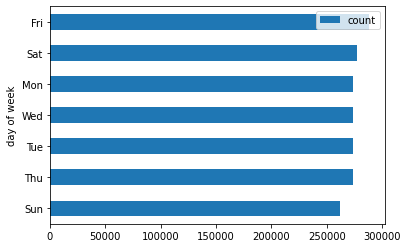

In [60]:
df.sort_values("count").plot.barh(x="day of week", y = "count")